# Setup Data

## Import from Kaggle

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 110MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s]


In [6]:
!dir

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

## Fix validation/testing size

In [8]:
!pip install glob2

In [9]:
from glob import glob
import shutil

# Get list of files in each directory
val_normal = glob('chest_xray/val/NORMAL/*')
val_pneumonia = glob('chest_xray/val/PNEUMONIA/*')
test_normal = glob('chest_xray/test/NORMAL/*')
test_pneumonia = glob('chest_xray/test/PNEUMONIA/*')

# Move files from test to validation to ensure even 50/50 split
num_normal_to_move = int(len(test_normal)/2) - int(len(val_normal)/2)
for filepath in test_normal[:num_normal_to_move]:
  new_path = filepath.replace('test', 'val')
  shutil.move(filepath, new_path)

# Move files from test to validation to ensure even 50/50 split
num_pneumonia_to_move = int(len(test_pneumonia)/2) - int(len(val_pneumonia)/2)
for filepath in test_pneumonia[:num_pneumonia_to_move]:
  new_path = filepath.replace('test', 'val')
  shutil.move(filepath, new_path)

In [10]:
print(len(glob('chest_xray/val/NORMAL/*')))
print(len(glob('chest_xray/val/PNEUMONIA/*')))
print(len(glob('chest_xray/test/NORMAL/*')))
print(len(glob('chest_xray/test/PNEUMONIA/*')))

121
199
121
199


## Augment Data

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Create image data generators for training and validation dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=False)
val_datagen = ImageDataGenerator(rescale=1./225)

In [12]:
# Generate data for training and validation dataset from directory
train_set = train_datagen.flow_from_directory('chest_xray/train',
                                              target_size = (224, 224),
                                              batch_size = 4,
                                              class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('chest_xray/val',
                                          target_size = (224, 224),
                                          batch_size = 1,
                                          class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


# Model

## Develop Model

In [13]:
!pip install tensorflow
!pip install keras
!pip install scipy
!pip install matplotlib

In [14]:
from keras.models import Model
from keras.layers import Flatten,Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plot
from glob import glob

In [15]:
# Image dimensions
IMAGESHAPE = [224, 224, 3]

# Load VGG16 model
vgg_model = VGG16(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [16]:
# Freeze layers of the VGG16 model
for each_layer in vgg_model.layers:
    each_layer.trainable = False

In [17]:
classes = glob('chest_xray/train/*')
classes

['chest_xray/train/NORMAL', 'chest_xray/train/PNEUMONIA']

In [18]:
# Flatten output layer to 1 dimension
flatten_layer = Flatten()(vgg_model.output)
# Add final layer for classification
prediction = Dense(len(classes), activation='sigmoid')(flatten_layer)

In [19]:
final_model = Model(inputs=vgg_model.input, outputs=prediction)
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
final_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## Train Model

In [21]:
train_history = final_model.fit(
  train_set,
  validation_data=val_set,
  epochs=20,
  steps_per_epoch=len(train_set)/4,
  validation_steps=len(val_set)
)

Epoch 1/20
326/326 [==============================] - 49s 114ms/step - loss: 0.3010 - accuracy: 0.8988 - val_loss: 0.4973 - val_accuracy: 0.8781
Epoch 2/20
326/326 [==============================] - 40s 122ms/step - loss: 0.2555 - accuracy: 0.9363 - val_loss: 0.4491 - val_accuracy: 0.9156
Epoch 3/20
326/326 [==============================] - 37s 113ms/step - loss: 0.2683 - accuracy: 0.9340 - val_loss: 0.4881 - val_accuracy: 0.8813
Epoch 4/20
326/326 [==============================] - 37s 114ms/step - loss: 0.2191 - accuracy: 0.9433 - val_loss: 0.4472 - val_accuracy: 0.9000
Epoch 5/20
326/326 [==============================] - 38s 117ms/step - loss: 0.2518 - accuracy: 0.9486 - val_loss: 0.3915 - val_accuracy: 0.9219
Epoch 6/20
326/326 [==============================] - 38s 117ms/step - loss: 0.1949 - accuracy: 0.9502 - val_loss: 0.5723 - val_accuracy: 0.8938
Epoch 7/20
326/326 [==============================] - 38s 116ms/step - loss: 0.4129 - accuracy: 0.9264 - val_loss: 0.4438 - val_ac

## Training and Validation Performance

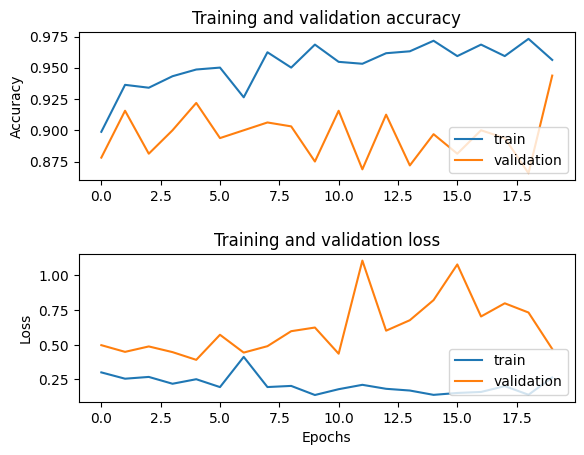

In [22]:
import matplotlib.pyplot as plt

train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs = range(len(train_acc))

# Visualize training and validation accuracy
plt.subplot(2,1,1)
plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, val_acc, label="validation")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc="lower right")

# Visualize training and validation loss
plt.subplot(2,1,2)
plt.plot(epochs, train_loss, label="train")
plt.plot(epochs, val_loss, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend(loc="lower right")

plt.subplots_adjust(hspace=0.5)

plt.show()

In [23]:
final_model.save('model.h5')

## Model Evaluation

### Test Model

In [24]:
import numpy as np
from PIL import Image
import pandas as pd
import os

def load_image_into_numpy_array(image):
  # Convert image to numpy array
  image = image.convert('RGB')
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def predict_image(filename):
  # Load and process image
  image = Image.open(filename).resize((224, 224))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)

  # Predict confidence of normal or pneumonia diagnosis
  confidence = final_model.predict(expanded)[0]
  normal_confidence = confidence[0]
  pneumonia_confidence = confidence[1]

  # Output prediction
  if normal_confidence > pneumonia_confidence:
    return "normal", normal_confidence, pneumonia_confidence
  elif normal_confidence <= pneumonia_confidence:
    return "pneumonia", normal_confidence, pneumonia_confidence

In [25]:
results = []

# Predict normal chest xrays
for image in os.listdir('chest_xray/test/NORMAL'):
  filepath = 'chest_xray/test/NORMAL'+"/"+image
  prediction, normal_confidence, pneumonia_confidence = predict_image(filepath)
  results.append([filepath, image, "normal", prediction, normal_confidence, pneumonia_confidence])

# Predict pneumonia chest xrays
for image in os.listdir('chest_xray/test/PNEUMONIA'):
  filepath = 'chest_xray/test/PNEUMONIA'+"/"+image
  prediction, normal_confidence, pneumonia_confidence = predict_image(filepath)
  results.append([filepath, image, "pneumonia", prediction, normal_confidence, pneumonia_confidence])

# Store results into dataframe
df = pd.DataFrame(data=results, columns=["filepath", "filename", "label", "prediction", "normal confidence", "pneumonia confidence"])

print("Done inference!")

1/1 [==============================] - 0s 22ms/step
Done inference!


In [26]:
df

,filepath,filename,label,prediction,normal confidence,pneumonia confidence
0,chest_xray/test/NORMAL/IM-0081-0001.jpeg,IM-0081-0001.jpeg,normal,normal,9.280872e-01,0.020500
1,chest_xray/test/NORMAL/NORMAL2-IM-0105-0001.jpeg,NORMAL2-IM-0105-0001.jpeg,normal,normal,9.931164e-01,0.003061
2,chest_xray/test/NORMAL/IM-0019-0001.jpeg,IM-0019-0001.jpeg,normal,normal,9.999614e-01,0.000015
3,chest_xray/test/NORMAL/NORMAL2-IM-0290-0001.jpeg,NORMAL2-IM-0290-0001.jpeg,normal,normal,9.955949e-01,0.001655
4,chest_xray/test/NORMAL/NORMAL2-IM-0132-0001.jpeg,NORMAL2-IM-0132-0001.jpeg,normal,normal,9.634120e-01,0.009108
...,...,...,...,...,...,...
315,chest_xray/test/PNEUMONIA/person100_bacteria_4...,person100_bacteria_477.jpeg,pneumonia,pneumonia,5.080213e-06,0.999985
316,chest_xray/test/PNEUMONIA/person1_virus_12.jpeg,person1_virus_12.jpeg,pneumonia,pneumonia,4.078554e-07,0.999999
317,chest_xray/test/PNEUMONIA/person114_bacteria_5...,person114_bacteria_546.jpeg,pneumonia,pneumonia,1.154823e-08,1.000000
318,chest_xray/test/PNEUMONIA/person77_virus_139.jpeg,person77_virus_139.jpeg,pneumonia,pneumonia,6.348412e-06,0.999977


In [32]:
def show_df_row(row):
  # Get filepath
  image_path = row["filepath"]
  # Predict normal or pneumonia
  prediction, normal_confidence, pneumonia_confidence = predict_image(image_path)

  # Load Image
  image = Image.open(image_path).resize((224, 224))
  img = load_image_into_numpy_array(image)

  # Title
  title = f'Image: {row["filename"]}\n' \
  f'Label: {row["label"]}\n' \
  f'Prediction: {row["prediction"]}\n' \
  f'Normal Score: {row["normal confidence"]}\n' \
  f'Pneumonia Score: {row["pneumonia confidence"]}'

  # Plot
  plt.title(title)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  return

1/1 [==============================] - 0s 41ms/step


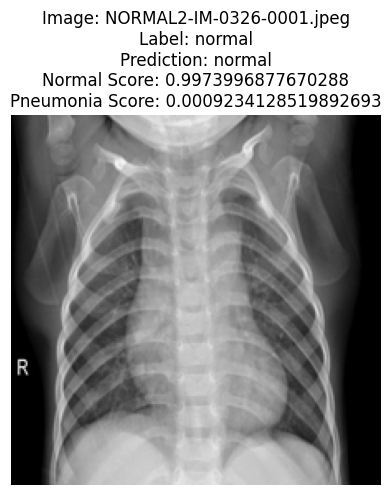

In [33]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

### Model Metrics

In [29]:
!pip install scikit-learn

In [30]:
from sklearn import metrics
accuracy = "%.3f" % metrics.accuracy_score(df['label'], df['prediction'])
precision = "%.3f" % metrics.precision_score(df['label'], df['prediction'], pos_label='pneumonia')
recall = "%.3f" % metrics.recall_score(df['label'], df['prediction'], pos_label='pneumonia')
accuracy, precision, recall

('0.916', '0.884', '0.995')

### Confusion Matrix

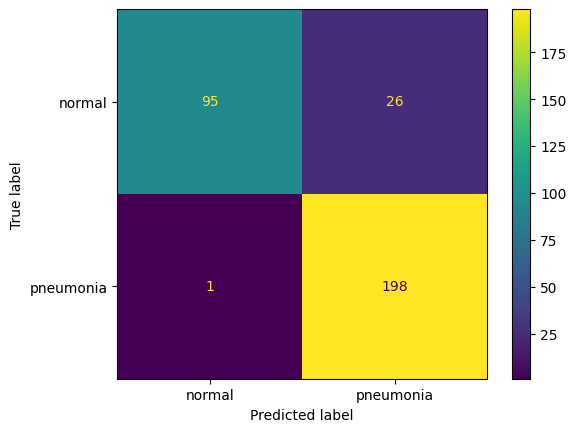

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['label'], df['prediction'], labels=['normal', 'pneumonia'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['normal', 'pneumonia'])
disp.plot()

plt.show()